In [ ]:
from typing import Self
from random import randint
from collections.abc import Callable

import PIL.Image
import torch
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchvision.transforms.functional import pil_to_tensor
from matplotlib import pyplot as plt

In [ ]:
def preprocess(image: PIL.Image.Image) -> torch.Tensor:
    return pil_to_tensor(image).squeeze(0).div(255).round().to(torch.int32)


def image_to_spin_pattern(image: torch.Tensor) -> torch.Tensor:
    return (image * 2 - 1).to(torch.int32)


def spin_pattern_to_image(tensor: torch.Tensor) -> torch.Tensor:
    return ((tensor + 1) / 2).to(torch.int32)


def obscure(image: torch.Tensor) -> torch.Tensor:
    rows = image.shape[0]
    obscured_image = image.clone()
    obscured_image[rows // 2 :, ...] = 0
    return obscured_image


def display(images: torch.Tensor | list[torch.Tensor], title: str | None = None) -> None:
    if isinstance(images, list):
        images = torch.stack(images)

    if images.min() < 0:
        images = spin_pattern_to_image(images)

    match images.ndim:
        case 3:
            grid = (
                make_grid(images.unsqueeze(1) * 255, pad_value=255)
                .permute((1, 2, 0))
                .numpy()
            )
            plot = plt.imshow(grid, cmap="grey")

        case 2:
            plot = plt.imshow(images.numpy(), cmap="grey")

        case other:
            raise ValueError(f"Invalid input dimensionality. Expected 2 or 3-dimensional tensor, got {other}")

    plot.axes.set_title(title or "")
    plot.axes.set_axis_off()
    plt.show()

In [ ]:
class ClassicalHopfieldNetwork:
    size: int
    weights: torch.Tensor
    biases: torch.Tensor

    def __init__(self, size: int, neuron_fire_threshold: float) -> None:
        assert 0 < neuron_fire_threshold < 1

        self.size = size
        self.weights = torch.zeros((size, size), dtype=torch.float32)
        self.biases = torch.full((size,), neuron_fire_threshold, dtype=torch.float32)

    def fit(self, data: torch.Tensor) -> Self:
        match data.shape:
            case n_records, n_dimensions:
                assert n_records > 0
                assert n_dimensions == self.size

            case other:
                raise ValueError(f"Invalid input shape. Expected 2-dimensional tensor (n_records x n_features), got {other}")

        assert data.dtype == torch.int32

        self.weights[...] = data.T @ data / n_records
        self.weights.diagonal()[...] = 0.0

        return self

    def predict(self, data: torch.Tensor) -> torch.Tensor:  # TODO: Remove
        assert data.shape == (self.size,)
        assert data.dtype == torch.int32

        state = data
        new_state = torch.sign(self.weights @ state.to(torch.float32) - self.biases).to(
            torch.int32
        )

        while not torch.equal(state, new_state) or torch.equal(state, -new_state):
            state = new_state
            new_state = torch.sign(
                self.weights @ state.to(torch.float32) - self.biases
            ).to(torch.int32)

        return state

    def predict_async(self, data: torch.Tensor) -> torch.Tensor:
        assert data.shape == (self.size,)
        assert data.dtype == torch.int32

        state = data.reshape(-1, 1).to(torch.float32, copy=True)

        for i in range(self.size):
            preactivation = self.weights[i, :] @ state - self.biases[i]
            activation = torch.sign(preactivation)
            state[i] = activation

        return state.flatten().to(torch.int32)

    def predict_async_stochastic(  # TODO: Remove
        self, data: torch.Tensor, max_iterations: int = 1000
    ) -> torch.Tensor:
        assert data.shape == (self.size,)
        assert data.dtype == torch.int32

        state = data.reshape(-1, 1).to(torch.float32, copy=True)

        for _ in range(max_iterations):
            i = randint(0, self.size - 1)
            preactivation = self.weights[i, :] @ state - self.biases[i]
            activation = torch.sign(preactivation)
            state[i] = activation

        return state.flatten().to(torch.int32)

In [ ]:
circle = torch.tensor(((-1, -1, -1), (-1, 1, -1), (-1, -1, -1)), dtype=torch.int32)
cross = torch.tensor(((-1, 1, -1), (1, -1, 1), (-1, 1, -1)), dtype=torch.int32)
cross_and_circle_network_input = torch.stack((circle.flatten(), cross.flatten()))

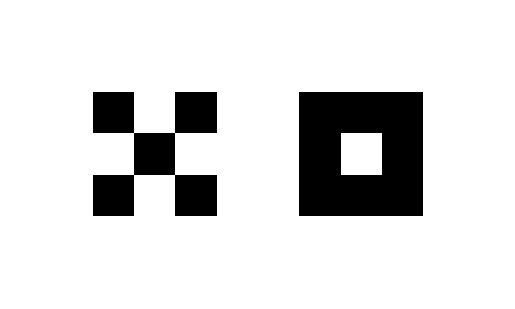

In [76]:
display([cross, circle])

In [59]:
cross_and_circle_network = ClassicalHopfieldNetwork(9, 0.3).fit(cross_and_circle_network_input)

In [ ]:
blank_image = torch.full((3, 3), -1, dtype=torch.int32)
recalled_image = cross_and_circle_network.predict_async(blank_image.flatten()).reshape(3, 3)
display([blank_image, recalled_image], "Crosses & Circles - example of inference")

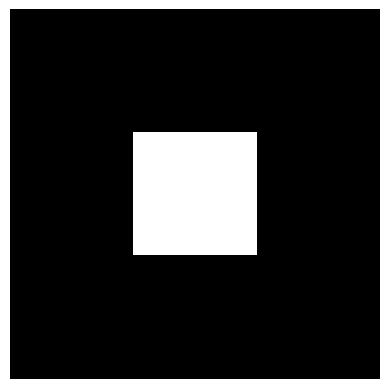

In [ ]:
display(cross_and_circle_network.predict(torch.zeros(9, dtype=torch.int32)).reshape(3, 3))

In [47]:
def extract_digit_examples(mnist: MNIST) -> dict[int, torch.Tensor]:
    all_digits = dict()

    for image, label in mnist:
        all_digits.setdefault(label, image)

        if all(i in all_digits for i in range(10)):
            break

    return all_digits

In [48]:
mnist_train = MNIST("./data", train=True, transform=preprocess, download=True)
mnist_examples = extract_digit_examples(mnist_train)

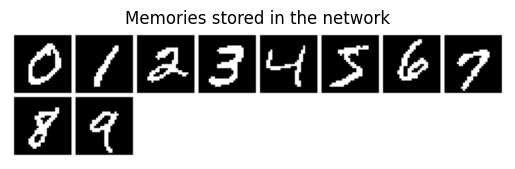

In [51]:
display([mnist_examples[digit] for digit in range(10)], title="Memories stored in the network")

In [52]:
mnist_network_input = image_to_spin_pattern(torch.stack([digit.flatten() for digit in mnist_examples.values()]))

In [73]:
mnist_network = ClassicalHopfieldNetwork(
    size=28 * 28,
    neuron_fire_threshold=0.5,
).fit(mnist_network_input)

In [74]:
zero = image_to_spin_pattern(mnist_examples[4])
zero_obscured = image_to_spin_pattern(obscure(mnist_examples[4]))
zero_recalled = mnist_network.predict_async(zero_obscured.flatten()).reshape(28, 28)

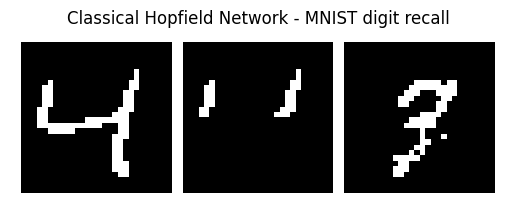

In [75]:
display([zero, zero_obscured, zero_recalled], title="Classical Hopfield Network - MNIST digit recall")

In [ ]:
class InteractionFunction:
    function: Callable[[torch.Tensor], torch.Tensor]
    derivative: Callable[[torch.Tensor], torch.Tensor]

    def __init__(
        self,
        function: Callable[[torch.Tensor], torch.Tensor],
        derivative: Callable[[torch.Tensor], torch.Tensor],
    ) -> None:
        self.function = function
        self.derivative = derivative

    def __call__(self, argument: torch.Tensor) -> torch.Tensor:
        return self.function(argument)


class PolynomialInteraction(InteractionFunction):
    degree: int

    def __init__(self, degree: int) -> None:
        super().__init__(
            function=lambda x: x**degree,
            derivative=lambda x: degree * x ** (degree - 1),
        )
        self.degree = degree


class ExponentialInteraction(InteractionFunction):
    def __init__(self) -> None:
        super().__init__(function=lambda x: x.exp(), derivative=lambda x: x.exp())


class ModernHopfieldNetwork:
    size: int
    interaction: InteractionFunction
    training_data: torch.Tensor
    weights: torch.Tensor
    biases: torch.Tensor

    def __init__(self, size: int, neuron_fire_threshold: float, interaction: InteractionFunction) -> None:
        assert 0 < neuron_fire_threshold < 1

        self.size = size
        self.interaction = interaction
        self.training_data = torch.zeros((1, size), dtype=torch.int32)
        self.weights = torch.zeros((size, size), dtype=torch.float32)
        self.biases = torch.full((size,), neuron_fire_threshold, dtype=torch.float32)

    def fit(self, data: torch.Tensor) -> Self:
        match data.shape:
            case n_records, n_dimensions:
                assert n_records > 0
                assert n_dimensions == self.size

            case other:
                raise ValueError(f"Invalid input shape. Expected 2-dimensional tensor (n_records x n_features), got {other}")

        assert data.dtype == torch.int32
        self.training_data = data.to(torch.float32, copy=True)

        return self
    
    def energy(self, state: torch.Tensor) -> torch.Tensor:
        n_memories = self.training_data.shape[0]
        
        # The original paper does not discuss the numerical properties of the algorithm.
        # When using high-degree interactions (e.g. exponent, polynomial with degree > 15),
        # especially in large networks with lots of memories,
        # the energy can easily exceed the range of float32. 
        #
        # Dividing the projected state by the number of memories does not affect the convergence
        # and helps to keep the energy at reasonable level, making the algorithm more efficient and scalable.
        projection = self.training_data @ state / n_memories
        
        return -torch.sum(self.interaction(projection))

    def predict_async(self, data: torch.Tensor) -> torch.Tensor:
        assert data.shape == (self.size,)
        assert data.dtype == torch.int32

        state = data.reshape(-1, 1).to(torch.float32, copy=True)

        for i in range(self.size):
            state[i] = 1
            energy_with_one = self.energy(state)

            state[i] = -1
            energy_with_minus_one = self.energy(state)

            state[i] = 1 if energy_with_one < energy_with_minus_one else -1

        return state.flatten().to(torch.int32)
    
    def predict_async_stochastic(self, data: torch.Tensor, max_iterations: int) -> torch.Tensor:  # TODO: Remove
        assert data.shape == (self.size,)
        assert data.dtype == torch.int32

        state = data.reshape(-1, 1).to(torch.float32, copy=True)

        for _ in range(max_iterations):
            i = randint(0, self.size - 1)

            state[i] = 1
            energy_with_one = self.energy(state)

            state[i] = -1
            energy_with_minus_one = self.energy(state)

            state[i] = 1 if energy_with_one < energy_with_minus_one else -1

        return state.flatten().to(torch.int32)

In [ ]:
mnist_modern_network = ModernHopfieldNetwork(
    size=28 * 28,
    neuron_fire_threshold=0.5,
    interaction=PolynomialInteraction(15),
).fit(mnist_network_input)

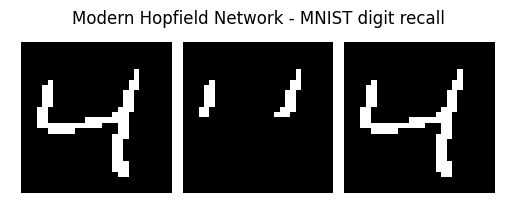

In [70]:
digit = image_to_spin_pattern(mnist_examples[4])
digit_obscured = image_to_spin_pattern(obscure(mnist_examples[4]))
digit_recalled = mnist_modern_network.predict_async(digit_obscured.flatten()).reshape(28, 28)
display([digit, digit_obscured, digit_recalled], title="Modern Hopfield Network - MNIST digit recall")